In [1]:
import os,math,random, gc,datetime
import platform
import logging
logging.getLogger().setLevel(logging.CRITICAL)

#package imports
import numpy as np
import pandas as pd
from tqdm import tqdm

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#local imports
from utils.helpers import find_play_type
from utils.logging import create_logger

#Stats imports
import statsmodels as sm
from scipy import stats

#File paths below
#check kaggle or local
if platform.platform() == 'Linux-5.15.133+-x86_64-with-glibc2.31':
    FILE_PATH = '/kaggle/input/nfl-big-data-bowl-2024'
else:
    FILE_PATH = './nfl-big-data-bowl-2024'
GAMES_PATH = os.path.join(FILE_PATH,'games.csv')
PLAYS_PATH = os.path.join(FILE_PATH,'plays.csv')
PLAYERS_PATH = os.path.join(FILE_PATH,'players.csv')
TACKLES_PATH = os.path.join(FILE_PATH,'tackles.csv')

#Tracking weeks
WEEK1_PATH = os.path.join(FILE_PATH,'tracking_week_1.csv')
WEEK2_PATH = os.path.join(FILE_PATH,'tracking_week_2.csv')
WEEK3_PATH = os.path.join(FILE_PATH,'tracking_week_3.csv')
WEEK4_PATH = os.path.join(FILE_PATH,'tracking_week_4.csv')
WEEK5_PATH = os.path.join(FILE_PATH,'tracking_week_5.csv')
WEEK6_PATH = os.path.join(FILE_PATH,'tracking_week_6.csv')
WEEK7_PATH = os.path.join(FILE_PATH,'tracking_week_7.csv')
WEEK8_PATH = os.path.join(FILE_PATH,'tracking_week_8.csv')
WEEK9_PATH = os.path.join(FILE_PATH,'tracking_week_9.csv')


logger = create_logger('./output/log.txt','basicModel')

Logger initialized: basicModel


### Load in all data

In [2]:
games_df = pd.read_csv(GAMES_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
tackles_df = pd.read_csv(TACKLES_PATH)

#tracking week 1
week1_df = pd.read_csv(WEEK1_PATH)
week2_df = pd.read_csv(WEEK2_PATH)
week3_df = pd.read_csv(WEEK3_PATH)
week4_df = pd.read_csv(WEEK4_PATH)
week5_df = pd.read_csv(WEEK5_PATH)
week6_df = pd.read_csv(WEEK6_PATH)
week7_df = pd.read_csv(WEEK7_PATH)
week8_df = pd.read_csv(WEEK8_PATH)
week9_df = pd.read_csv(WEEK9_PATH)

#concat all weeks
all_weeks = pd.concat([week1_df,week2_df,week3_df,week4_df,week5_df,week6_df,week7_df,week8_df,week9_df])
all_weeks = all_weeks.merge(players_df.loc[:,['nflId','position']],how='left')
display(all_weeks.sample(4))

#find all pass plays and run plays
pass_plays = find_play_type(plays_df,'pass')
pass_index = plays_df[plays_df['playDescription'].isin(pass_plays)].index
pass_plays_df = plays_df.iloc[pass_index]
run_plays_df = plays_df.loc[~plays_df.index.isin(pass_index)]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,position
384971,2022091103,719,46138.0,B.J. Hill,8,2022-09-11 13:34:08.200000,92.0,CIN,right,81.03,15.62,4.05,1.30,0.42,94.43,106.24,NaN,DT
9070013,2022102306,3897,43404.0,De'Vondre Campbell,27,2022-10-23 16:10:25.799999,59.0,GB,left,75.33,10.24,4.36,2.09,0.45,231.42,228.45,NaN,ILB
9318701,2022102309,2612,54474.0,Charles Cross,20,2022-10-23 18:34:07.200000,67.0,SEA,left,105.17,21.25,2.57,0.80,0.27,283.87,285.12,NaN,T
10071552,2022103003,480,53436.0,Penei Sewell,16,2022-10-30 13:19:53.299999,58.0,DET,right,34.27,25.34,1.77,0.66,0.20,83.91,91.40,NaN,T


Number of matches for pass: 5646


In [11]:
plays_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2'],
      dtype='object')

## Some Data Organization

In [3]:
# 8 mins
# tracking_run_index = []
# for i,j in tqdm(zip(run_plays_df['gameId'],run_plays_df['playId'])):
#     ind = all_weeks.loc[(all_weeks['gameId'] == i) & (all_weeks['playId'] == j)].index
#     tracking_run_index = tracking_run_index + ind.to_list()

# 8.5 mins
# for i in tqdm(run_plays_df[['gameId','playId']].itertuples()):
#     ind = all_weeks.loc[(all_weeks['gameId'] == i[1]) & (all_weeks['playId'] == i[2])].index
#     tracking_run_index = tracking_run_index + ind.to_list()
if not os.path.exists('./output/run_play_tracking.csv'):
    logger.info('Creating run play tracking csv...')
    #2 mins
    def apply_func(gameId,playId):
        ind = all_weeks.loc[(all_weeks['gameId'] == gameId) & (all_weeks['playId'] == playId)].index.to_list()
        return ind

    run_plays = [apply_func(x,y) for x,y in tqdm(zip(run_plays_df['gameId'],run_plays_df['playId']))]
    tracking_run_index = [item for sublist in run_plays for item in sublist]

    run_play_tracking = all_weeks.iloc[tracking_run_index]
    run_play_tracking.to_csv('./output/run_play_tracking.csv')
else:
    logger.info('Reading run play tracking csv...')
    run_play_tracking = pd.read_csv('./output/run_play_tracking.csv')

Creating run play tracking csv...


6840it [03:54, 29.19it/s]


In [180]:
at_snap = run_play_tracking[run_play_tracking['event'] == 'ball_snap']


test_df = at_snap[at_snap['position'] == 'SS'].copy()
test_df = test_df.merge(plays_df.loc[:,['gameId','playId','playResult']],on=['gameId','playId'],how='left')

for play in tqdm(test_df.itertuples()):
    frame = play.frameId

    #frames = play[play['frameId'] == frame]
    ball = at_snap.loc[(at_snap['displayName']=='football') & (at_snap['frameId']==frame) & (at_snap['playId']==play.playId) & (at_snap['gameId']==play.gameId)]

    try:
        dist_to_ball = np.sqrt((play.x -ball['x'])**2 + (play.y-ball['y'])**2)
        test_df.loc[play.Index,'dist_to_ball'] = dist_to_ball.values[0]
    except:
        pass



657it [00:05, 117.50it/s]

In [142]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
RS = 1106

class BasicModel(BaseEstimator):
    '''
    Takes the data and fits basic models. In custom class for pipeline tweaks. Obviously unnecesary
    '''
    def __init__(self,kwargs):
        self.kwargs = kwargs
        self.rf = RandomForestRegressor(**{'n_estimators':kwargs['n_estimators'],'max_depth':kwargs['max_depth'],'random_state':RS})
        self.gbm = GradientBoostingRegressor(**kwargs)
        self.scale = StandardScaler()
        self.scaled = False
        self.rf_preds = None
        self.gbm_preds = None
        self.type = 'rf'
    
    def fit(self,X,y,scale_data=False):
        '''model fits. can scale if needed'''
        if scale_data:
            X = self.scale.fit_transform(X)
            self.scaled = True
        self.rf.fit(X,y)
        self.gbm.fit(X,y)

    def predict(self,X,y=None, gbm=False):
        '''basic predictions'''
        if self.scaled:
            X = self.scale.transform(X)

        if gbm:
            preds =  self.gbm.predict(X)
            self.gbm_preds = preds
        else:
            preds = self.rf.predict(X)
            self.rf_preds = preds

        self.preds = True
        return preds

    def score(self,X,y,gbm_pred=False):
        '''Can self score if X and y are passed in otherwise use sklearn's score method'''
        if gbm_pred:
            self.gbm_preds = self.predict(X,gbm=gbm_pred)
            return mse(y,self.gbm_preds)
        else:
            self.rf_preds = self.predict(X)
            return mse(y,self.rf_preds)
        

test_df.dropna(inplace=True)
test_cols = ['dist_to_ball','y','x','s','a','dir']

X = test_df[test_cols]
y = test_df['playResult']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=RS)

params = {
    "n_estimators": 2000,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.001,
    "loss": "squared_error",
    "random_state": RS
}

model = BasicModel(params)

model.fit(X_train,y_train,scale_data=True)
gbm_score = model.score(X_test, y_test,gbm_pred=True)
rf_score = model.score(X_test,y_test)

result_median = [y.median() for i in range(len(y_test))]
median_test = mse(y_test,result_median)


print(f'MSE for GBM: {gbm_score:.3f}')
print(f'MSE for RF: {rf_score:.3f}')
print(f'MSE for Median: {median_test:.3f}')
print(f'Improvement over median GBM: {median_test - gbm_score:.3f}')
print(f'Improvement over median RF: {median_test - rf_score:.3f}')



MSE for GBM: 49.729
MSE for RF: 49.659
MSE for Median: 52.326
Improvement over median GBM: 2.598
Improvement over median RF: 2.667


## Linear model

In [177]:
#basic linear model
X_train1 = X_train.drop(columns=['s','dir']).copy()
X_train1['intercept'] = 1

linear_model = sm.OLS(y_train, X_train1).fit()

display(linear_model.summary())

coef = linear_model.params
change_in_unit = pd.DataFrame()
change_in_unit['coef'] = coef
change_in_unit['change_in_unit'] = np.exp(coef)
change_in_unit

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             playResult   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.841
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           1.72e-05
Time:                        14:46:57   Log-Likelihood:                -23195.
No. Observations:                6886   AIC:                         4.640e+04
Df Residuals:                    6881   BIC:                         4.643e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
dist_to_ball     0.2450      0.060      4.117      0.000       0.128       0.362
y                0.0143      0.021      0.674      0.500      -0.027       0.056
x               -0.0003      0.003     -0.104      0.917      -0.007       0.006
a               -0.3198      0.106     -3.028      0.002      -0.527      -0.113
intercept        2.8256      0.694      4.072      0.000       1.465       4.186
==============================================================================
Omnibus:                     5090.694   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153956.948
Skew:                           3.222   Prob(JB):                         0.00
Kurtosis:                      25.250   Cond. No.                         579.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,change_in_unit
dist_to_ball,0.245004,1.277626
y,0.014340,1.014443
x,-0.000345,0.999655
a,-0.319820,0.726280
intercept,2.825594,16.870965


c:\Users\batuu\anaconda3\envs\pythonProject\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


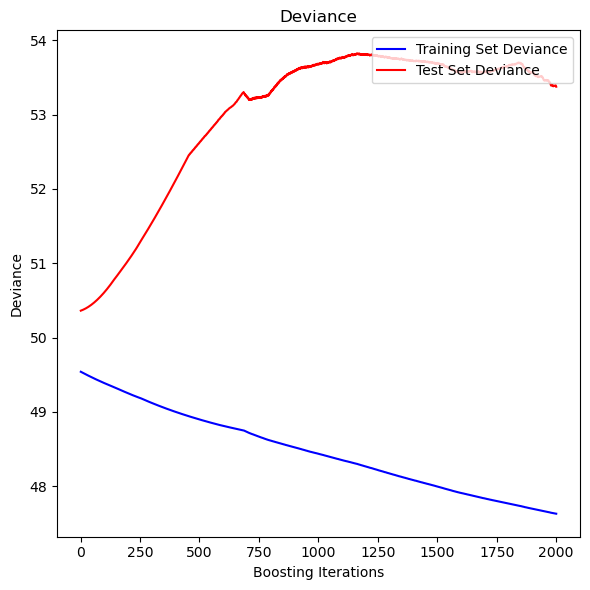

In [143]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.gbm.staged_predict(X_test)):
    test_score[i] = mse(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    model.gbm.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### Get the frames we might want to keep for a robust model based on movement

In [ ]:
frame_counts = {}
list_of_frames = []

#average frames
for game in tqdm(run_play_tracking['gameId'].unique()):
    frame_counts[game] = {}
    for play in run_play_tracking.loc[run_play_tracking['gameId'] == game]['playId'].unique():
        frames = run_play_tracking[(run_play_tracking['gameId'] == game) & (run_play_tracking['playId'] == play)]['frameId'].mean().astype(int)
        frame_counts[game][play] = frames
        list_of_frames.append(frames)

#trim the amount of plays with less than some percentile of frames. We need every play in a tensor to have the same amount of frames
#list_of_frames.sort()
frame_threshold = np.percentile(list_of_frames, 30)
print(frame_threshold)
        

100%|██████████| 17/17 [00:36<00:00,  2.16s/it]

14.399999999999977


In [ ]:
#only plays with more than the threshold selected. then we ONLY take those frames
#this is to make sure that every play has the same amount of frames

keep_plays = {}

for k,v in frame_counts.items():
    keep_plays[k] = []
    for k1,v1 in v.items():
        if v1 > frame_threshold:
            keep_plays[k].append(k1)

keep_plays

{2022091103: [3126,
  253,
  274,
  1672,
  611,
  632,
  4462,
  4631,
  1610,
  520,
  2611,
  2670,
  4154,
  1126,
  1150,
  2291,
  2315,
  852,
  881,
  1493,
  1565,
  3105,
  3825,
  5039,
  1228,
  2483,
  2511,
  1384,
  2719,
  955,
  1016,
  2955,
  1315,
  1363,
  3011,
  1700,
  364,
  388,
  2201,
  2222,
  3755,
  1947,
  1968,
  2037,
  3251,
  4686,
  1037,
  4279,
  4353,
  743,
  764,
  319,
  3613,
  3680,
  1105,
  111,
  2462,
  1926,
  3294,
  3389,
  1589,
  3464,
  4789,
  340,
  2172,
  902,
  4710],
 2022091112: [2370,
  2475,
  3454,
  3492,
  3530,
  1994,
  1613,
  2612,
  2640,
  3416,
  1458,
  2501,
  965,
  86,
  1539,
  573,
  3551,
  2886,
  2072,
  181,
  3627,
  3002,
  3029,
  1144,
  1165,
  2931,
  2981,
  3766,
  1501,
  62,
  2246,
  2294,
  2167,
  2225,
  1260,
  736,
  1560,
  3589,
  3176,
  2315,
  1207,
  3128,
  3672,
  3696,
  917,
  991],
 2022091107: [723,
  3669,
  3443,
  3026,
  1260,
  1378,
  254,
  275,
  2285,
  2314,
  1994,

## A model to look at run plays and play results
Will only look at x,y,s,a,dis(or o)

In [ ]:
import torch
import torch.nn as nn

NUM_SAMPLES = 800
NUM_FRAMES = 14
NUM_PLAYERS = 23
DIMENSION_NAMES = ['x','y','s','a','o']
DIMENSIONS = len(DIMENSION_NAMES)+1



class Preprocess(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Parameter(torch.randn(1,1,3))
        self.l2 = nn.Parameter(torch.randn(1,1,3))
        self.l3 = nn.Parameter(torch.randn(1,1,3))
        
    def forward(self,x):
        x = torch.cat([x,self.l1],dim=1)
        x = torch.cat([x,self.l2],dim=1)
        x = torch.cat([x,self.l3],dim=1)
        return x

#trying to create a tensor
def create_tensor(df):
    X = np.zeros([NUM_SAMPLES, NUM_FRAMES, NUM_PLAYERS, DIMENSIONS], dtype=np.float32)
    y = np.zeros([NUM_SAMPLES], dtype=np.int32)

    for i in df['gameId'].unique():
        for j in df.loc[df['gameId'] == i]['playId'].unique():
            for p in df.loc['nflId'].unique():
                pass
            
